In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse x

In [2]:
def design_mat_pol(x, p):
    n = len(x)
    phi_mat = np.ones((n, 1))
    for i in range(1, p + 1):
        phi_i = (x ** i).reshape(-1, 1)
        phi_mat = np.hstack((phi_mat, phi_i))
    return phi_mat

In [3]:
def design_mat_pwc(x, k):
    x_min = np.min(x)
    x_max = np.max(x)
    n = len(x)
    phi_mat = np.ones((n, 1))
    for i in range(1, k + 1):
        t = x_min + i * (x_max - x_min) / (k + 1)
        phi_i = (x > t)
        phi_mat = np.hstack((phi_mat, phi_i.reshape(-1, 1)))
    return phi_mat

In [4]:
def design_mat_pwl(x, k):
    x_min = np.min(x)
    x_max = np.max(x)
    n = len(x)
    phi_mat = np.hstack((np.ones((n, 1)), x.reshape(-1, 1)))
    for i in range(1, k + 1):
        t = x_min + i * (x_max - x_min) / (k + 1)
        phi_i = (x - t) * (x > t)
        phi_mat = np.hstack((phi_mat, phi_i.reshape(-1, 1)))
    return phi_mat

In [5]:
def np_predict(xmat,y):
    bhat = np.linalg.inv(xmat.T @ xmat)@ xmat.T @ y
    yhat = xmat @ bhat
    return yhat

In [6]:
def skl_precict(xmat,y):
    lr = linearRegression(fit_intercept=False)
    lr.fit(xmat, y)
    yhat = lr.predict(xmat)
    print('Rank:{}/{}'.format(lr.rank_,xmat.shape[1]))
    return yhat

In [7]:
def np_predict_new(phi_mat, y, phi_mat_new):
    b_hat = np.linalg.inv(phi_mat.T @ phi_mat) @ phi_mat.T @ y
    y_hat = phi_mat_new @ b_hat
    return y_hat

In [8]:
def skl_predict_new(phi_mat, y, phi_mat_new):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(phi_mat, y)
    y_hat = lr.predict(phi_mat_new)
    return y_hat

In [9]:
# Read temperature data from file
data = pd.read_csv('/Users/Vi/Desktop/surf_temp.csv')
data

,temp,year,month
0,11.50,1940,1
1,11.87,1940,2
2,12.52,1940,3
3,13.76,1940,4
4,14.75,1940,5
...,...,...,...
1012,15.91,2024,5
1013,16.66,2024,6
1014,16.91,2024,7
1015,16.82,2024,8


Processing

In [192]:
udf = pd.get_dummies(data['month'],drop_first=True, dtype=int)
xss = (data['year']-1940)/84
df = pd.concat([xss,udf],axis=1)

In [193]:
# x not only include year anymore.
x = df.values
y = data['temp'].values

In [194]:
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [195]:
#Train-validation-test split
x_tv, x_test, y_tv, y_test = train_test_split(
    x, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(
    x_tv, y_tv, test_size=1/3, random_state=1)

In [196]:
p = np.arange(1,11)
p

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

# Training on different p-values

In [197]:
n_p = len(p)
mse_vali_pol = np.empty(n_p)
for i in range(n_p):
    xmat = np.hstack((design_mat_pol(x_train[:,0],p[i]),x_train[:,1:]))
    xmat_new = np.hstack((design_mat_pol(x_vali[:,0],p[i]),x_vali[:,1:]))
    yhat = skl_predict_new(xmat,y_train,xmat_new)
    mse_vali_pol[i] = mse(y_vali,yhat)

In [198]:
mse_vali_pol

array([0.03179737, 0.02100598, 0.02105975, 0.02107016, 0.02151321,
       0.02151768, 0.02146495, 0.02171523, 0.02136507, 0.02126742])

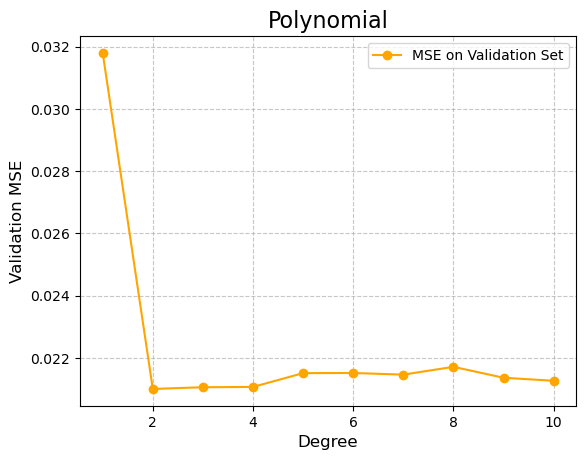

In [199]:
plt.plot(p, mse_vali_pol, marker='o', linestyle='-', label='MSE on Validation Set', color='orange')
plt.title('Polynomial', fontsize=16)  
plt.xlabel('Degree', fontsize=12)    
plt.ylabel('Validation MSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.legend(loc='best', fontsize=10) 
plt.show()

In [200]:
mse_vali_pol.min()

0.02100598002064821

In [201]:
np.argmin(mse_vali_pol)

1

Re-train model

In [202]:
x_train_pol = np.hstack((design_mat_pol(x_tv[:,0],2),x_tv[:,1:]))
x_test_pol = np.hstack((design_mat_pol(x_test[:,0],2),x_test[:,1:]))
yhat_test_pol = skl_predict_new(x_train_pol,y_tv,x_test_pol)

In [203]:
mse_test_pol = mse(yhat_test_pol,y_test)
mse_test_pol

0.02324321032575373

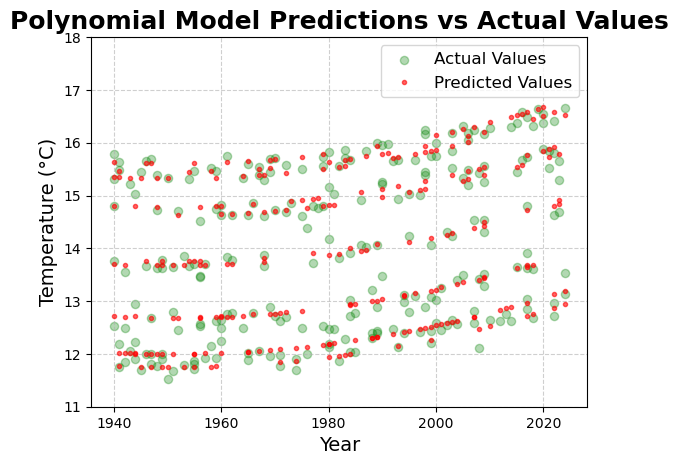

In [204]:
plt.scatter(x_test[:, 0]*84 + 1940, y_test, color='green', s=35, alpha=0.3, label='Actual Values')
plt.plot(x_test[:, 0]*84 +1940 , yhat_test_pol, 'r.',alpha=0.6,label='Predicted Values')
plt.title('Polynomial Model Predictions vs Actual Values', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.xticks([1940, 1960, 1980, 2000, 2020])
plt.yticks(range(11, 19))
plt.show()

# Piece-wise constant basis LBF
# 

In [205]:
k = np.arange(1,31)
k

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [206]:
n_k = len(k)
mse_vali_pwc = np.empty(n_k)
for i in range (n_k):
    xmat = np.hstack((design_mat_pwc(x_train[:,0],k[i]),x_train[:,1:]))
    xmat_new = np.hstack((design_mat_pwc(x_vali[:,0],k[i]),x_vali[:,1:]))
    yhat = skl_predict_new(xmat,y_train,xmat_new)
    mse_vali_pwc[i] = mse(y_vali,yhat)

In [207]:
mse_vali_pwc

array([0.06115991, 0.03812546, 0.0323274 , 0.03104668, 0.02924497,
       0.02065414, 0.02417979, 0.02044466, 0.02462605, 0.02030005,
       0.02470377, 0.02112916, 0.02065758, 0.02045143, 0.01999018,
       0.02044394, 0.01920362, 0.02111883, 0.02067523, 0.0202546 ,
       0.02067866, 0.01868826, 0.02050478, 0.01736259, 0.02032218,
       0.0200638 , 0.01837087, 0.01836437, 0.01819162, 0.01828215])

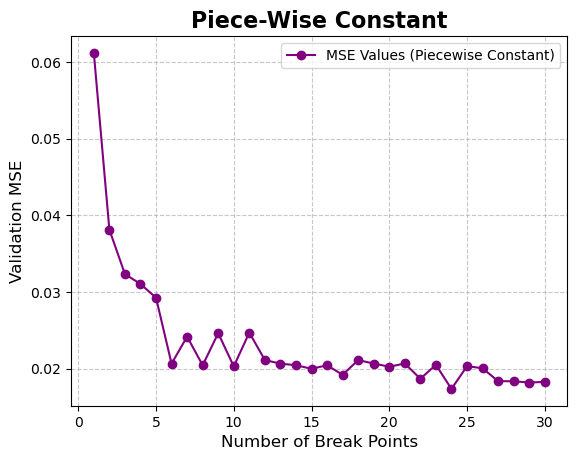

In [208]:
plt.plot(k, mse_vali_pwc, marker='o', linestyle='-', color='purple', label='MSE Values (Piecewise Constant)')
plt.title('Piece-Wise Constant', fontsize=16, fontweight='bold')
plt.xlabel('Number of Break Points', fontsize=12)
plt.ylabel('Validation MSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.show()

In [209]:
mse_vali_pwc.min()

0.017362587614227716

In [210]:
np.argmin(mse_vali_pwc)

23

Re-train Model

In [211]:
x_train_pwc = np.hstack((design_mat_pwc(x_tv[:,0],24),x_tv[:,1:]))
x_test_pwc = np.hstack((design_mat_pwc(x_test[:,0],24),x_test[:,1:]))
yhat_test_pwc = skl_predict_new(x_train_pwc,y_tv,x_test_pwc)

In [212]:
mse_test_pwc = mse(yhat_test_pwc, y_test)
mse_test_pwc

0.020550262157937163

plot

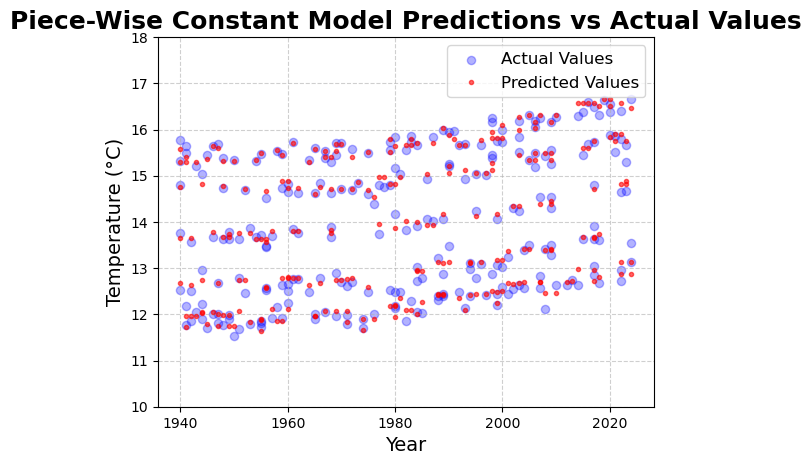

In [213]:
plt.scatter(x_test[:, 0]*84 + 1940, y_test, color='blue', s=35, alpha=0.3, label='Actual Values')
plt.plot(x_test[:, 0]*84 + 1940, yhat_test_pwc, 'r.',alpha=0.6,label='Predicted Values')
plt.title('Piece-Wise Constant Model Predictions vs Actual Values', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.xticks([1940, 1960, 1980, 2000, 2020])
plt.yticks(range(10, 19))
plt.show()

# Peice-wise Linear Basis LBF

In [214]:
k = np.arange(1,31)
k

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [215]:
n_k = len(k)
mse_vali_pwl = np.empty(n_k)
for i in range(n_k):
    xmat = np.hstack((design_mat_pwl(x_train[:,0],k[i]),x_train[:,1:]))
    xmat_new = np.hstack((design_mat_pwl(x_vali[:,0],k[i]),x_vali[:,1:]))
    yhat = skl_predict_new(xmat,y_train, xmat_new)
    mse_vali_pwl[i] = mse(y_vali,yhat)

In [216]:
mse_vali_pwl

array([0.02199306, 0.02067222, 0.02165389, 0.02119438, 0.02154077,
       0.02104248, 0.02011698, 0.02054361, 0.02100394, 0.02174609,
       0.02078856, 0.02145687, 0.02002061, 0.02102295, 0.02038377,
       0.01929837, 0.02136777, 0.01900966, 0.01967369, 0.01744004,
       0.01902778, 0.01866837, 0.0185401 , 0.01888549, 0.01750161,
       0.01746284, 0.01649825, 0.01769243, 0.01744359, 0.01690354])

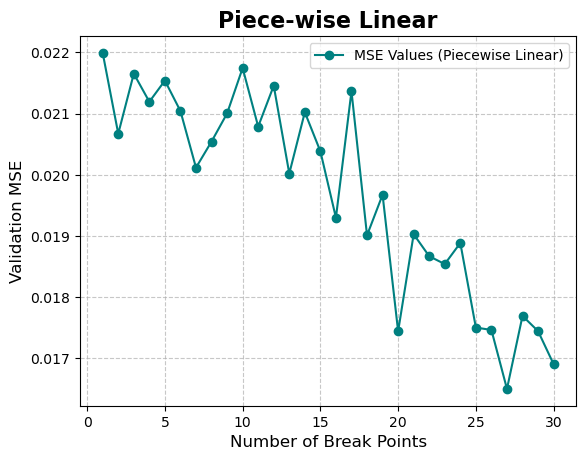

In [217]:
plt.plot(k, mse_vali_pwl, marker='o', linestyle='-', color='teal', label='MSE Values (Piecewise Linear)')
plt.title('Piece-wise Linear', fontsize=16, fontweight='bold')
plt.xlabel('Number of Break Points', fontsize=12)
plt.ylabel('Validation MSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.show()

In [218]:
mse_vali_pwl.min()

0.016498252648175366

In [219]:
np.argmin(mse_vali_pwl)

26

Re-train Model

In [220]:
x_train_pwl = np.hstack((design_mat_pwl(x_tv[:,0],27),x_tv[:,1:]))
x_test_pwl = np.hstack((design_mat_pwl(x_test[:,0],27),x_test[:,1:]))
yhat_test_pwl = skl_predict_new(x_train_pwl,y_tv,x_test_pwl)

In [221]:
mse_test_pwl = mse(yhat_test_pwl,y_test)
mse_test_pwl

0.01796732192099962

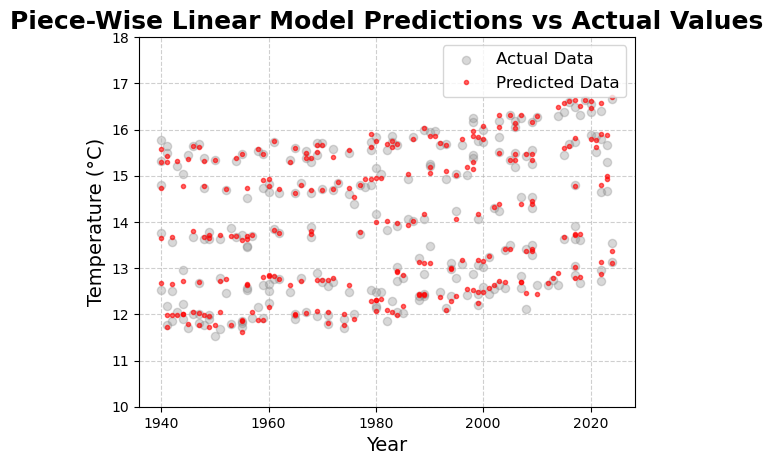

In [222]:
plt.scatter(x_test[:, 0]*84 + 1940, y_test, color='grey', s=35, alpha=0.3, label='Actual Data')
plt.plot(x_test[:, 0]*84 + 1940, yhat_test_pwl, 'r.',alpha=0.6,label='Predicted Data')
plt.title('Piece-Wise Linear Model Predictions vs Actual Values', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.xticks([1940, 1960, 1980, 2000, 2020])
plt.yticks(range(10, 19))
plt.show()

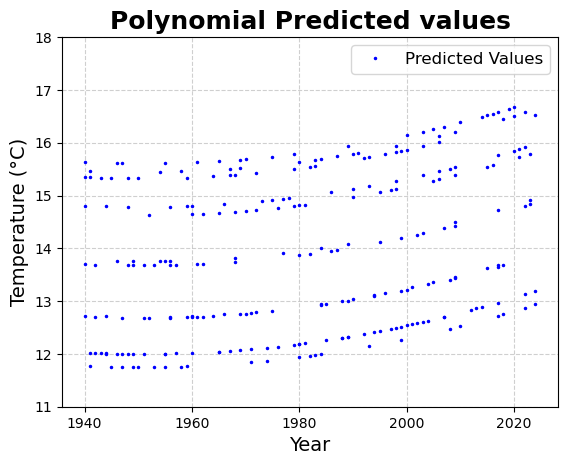

In [223]:
plt.plot(x_test[:, 0]*84 +1940 , yhat_test_pol, 'b.',markersize=3.0,alpha=1.0,label='Predicted Values')
plt.title('Polynomial Predicted values', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.xticks([1940, 1960, 1980, 2000, 2020])
plt.yticks(range(11, 19))
plt.show()

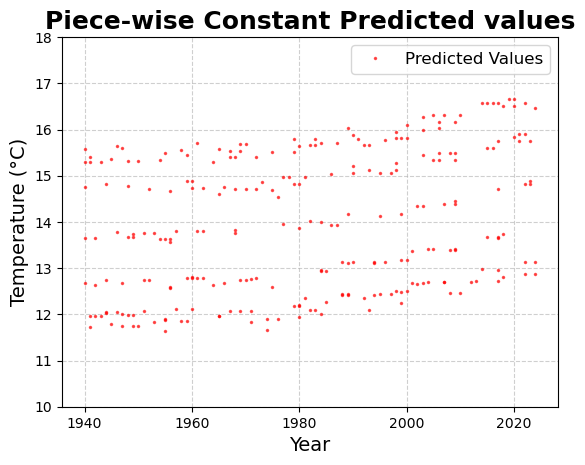

In [224]:
plt.plot(x_test[:, 0]*84 + 1940, yhat_test_pwc, 'r.',markersize=3.0,alpha=0.6,label='Predicted Values')
plt.title('Piece-wise Constant Predicted values', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.xticks([1940, 1960, 1980, 2000, 2020])
plt.yticks(range(10, 19))
plt.show()

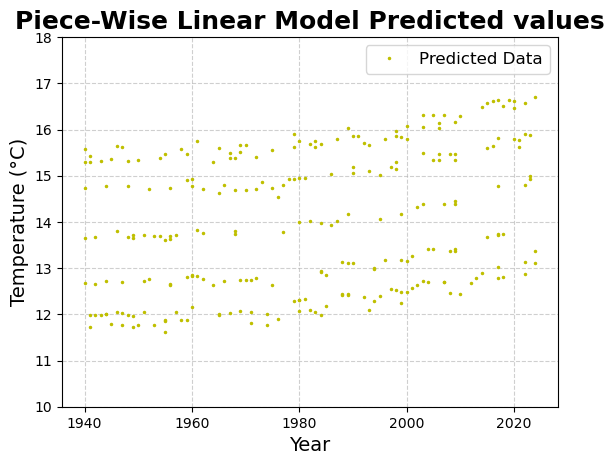

In [225]:
plt.plot(x_test[:, 0]*84 + 1940, yhat_test_pwl, 'y.', markersize=3.0, label='Predicted Data')
plt.title('Piece-Wise Linear Model Predicted values', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.xticks([1940, 1960, 1980, 2000, 2020])
plt.yticks(range(10, 19))
plt.show()

# Prediction

In [226]:
x_new = np.array([[1,0,0,0,0,0,0,0,0,1,0,0],
                  [1,0,0,0,0,0,0,0,0,0,1,0],
                  [1,0,0,0,0,0,0,0,0,0,0,1]]) 

In [227]:
x_new_pwl = np.hstack((design_mat_pwl(x_new[:,0],27),x_new[:,1:]))
yhat_new_pwl = skl_predict_new(x_train_pwl,y_tv,x_new_pwl)
yhat_new_pwl

array([14.37208794, 13.30013444, 12.61455261])